# Импорт нужных библиотек 

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.datasets import make_blobs

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# Загрузка данных

In [2]:
data = pd.read_csv('reddit_wsb.csv')
data.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


# Обработка и анализ данных

## Обработка текса

Для обработки текста написан такой токенизатор. Он заменяет некоторые не имеющие для нас смысла символы в тексте на пробелы, также делает ещё пару упрощений. Ну и, соответсвенно, делает саму токенизацию.

In [3]:
# ининциализируем лемматизатор
lemmatizer = WordNetLemmatizer()

#функция обработки текста. Функция убирает регистр, делает лемматизацию, убирает все лишние лишние символы,
#оставляя только буквы и цифры.
def preprocess(data):
    correct_text = []
    for text in data:
        correct = text.lower()
        correct = nltk.word_tokenize(correct)
        correct = ' '.join([lemmatizer.lemmatize(word) for word in correct])
        correct = re.sub("[^a-zA-Z0-9 ]", "", correct)
        correct_text.append(correct)
    data = np.array(correct_text)
    return data

In [4]:
title = data["title"]
title_mean = []

data_title = preprocess(title)
print(data_title)

['it s not about the money  it s about sending a message  '
 'math professor scott steiner say the number spell disaster for gamestop short'
 'exit the system' ...
 'unpinned daily discussion thread for february 19  2021'
 'daily discussion thread for february 19  2021'
 'kenny g uncovers the voice next episode ']


In [5]:
#Находим важность слов и переводим их в векторную форму
X = TfidfVectorizer().fit_transform(data_title)

#Находим среднее арифметическое полученного
for x in range(X.shape[0]):
    #Для проверки на NaN
    title = X[x].data
    if len(title) == 0:
        title= 0
    title_mean.append(np.mean(title))

#Создаем новую фичу
data['title_mean'] = title_mean

print(data['title_mean'])

0        0.351716
1        0.268097
2        0.526654
3        0.261344
4        0.238224
           ...   
34875    0.572055
34876    0.314745
34877    0.345103
34878    0.369715
34879    0.379554
Name: title_mean, Length: 34880, dtype: float64


## Визуализация корреляции фич

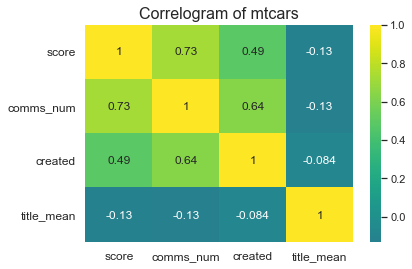

In [6]:
#Делаем корреляцию с помощью метода Спирмена
corr_spearman = data.corr(method = 'spearman')
sns.heatmap(corr_spearman, xticklabels=corr_spearman.columns, yticklabels=corr_spearman.columns, center=0, annot=True, cmap='viridis')
plt.title('Correlogram of mtcars', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Заметим, что корреляции между фичами "score", "comms_num" и "created" наибольшие, поэтому будем использовать их для обучение модели.

# Запуск алгоритма k-means

## Обучение модели

In [7]:
#Берем все необходимые данные
X = data[['score', 'comms_num', 'created']]
#Преобразовываем объекты и приводим к диапозону [0, 1]
X_scaled=MinMaxScaler().fit_transform(X)

#Счетчик для метода локтя 
model_scores= []
#Счетчик для анализа силуэтом
model_silhouette = []

list_k = list(range(2, 11))

for k in list_k:
    model = KMeans(n_clusters=k).fit(X_scaled)
    preds = model.predict(X_scaled)
    
    #Считаем очки для метода локтя 
    print("Score for number of cluster(s) {}: {}".format(k,model.score(X_scaled)))
    model_scores.append(-model.score(X_scaled))
    
    #Считаем очки для анализа силуэтом
    silhouette = silhouette_score(X_scaled,preds)
    model_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))
    
    #Смотрим, сколько объектов распределили на каждый кластер
    print("Cluster distribution for number of cluster(s) {}: {}".format(k,Counter(preds)))
    
    print('*'*100)

Score for number of cluster(s) 2: -54.764099973313996
Silhouette score for number of cluster(s) 2: 0.623839354712143
Cluster distribution for number of cluster(s) 2: Counter({1: 24130, 0: 10750})
****************************************************************************************************
Score for number of cluster(s) 3: -39.84053776052225
Silhouette score for number of cluster(s) 3: 0.6459324514998819
Cluster distribution for number of cluster(s) 3: Counter({0: 23941, 1: 10664, 2: 275})
****************************************************************************************************
Score for number of cluster(s) 4: -25.887235758890306
Silhouette score for number of cluster(s) 4: 0.7461527068922078
Cluster distribution for number of cluster(s) 4: Counter({0: 19752, 3: 12686, 1: 2181, 2: 261})
****************************************************************************************************
Score for number of cluster(s) 5: -14.385305570218334
Silhouette score for number o

# Методы оценки

## Метод локтя

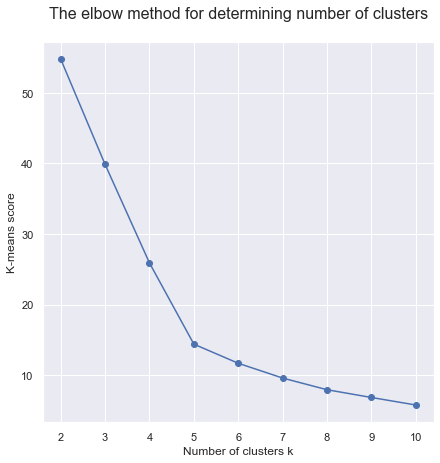

In [8]:
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.plot(list_k, model_scores, '-o')
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.xlabel('Number of clusters k')
plt.ylabel('K-means score');

Метод локтя показал, что хорошим решением будет использовать k = 5

## Анализ силуэтом

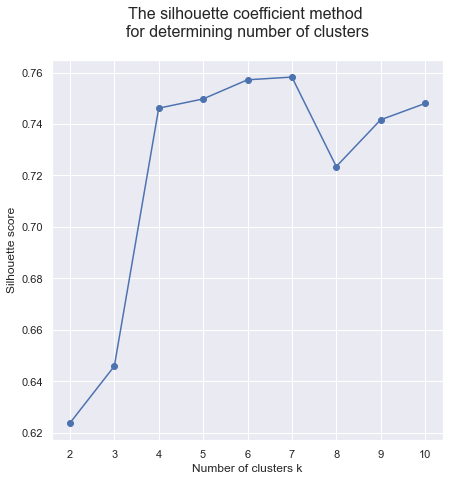

In [9]:
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.plot(list_k, model_silhouette, '-o')
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score');

А вот анализ силуэтом показал, что хорошим решением будет использовать k = 7. Коэффициент «силуэт» вычисляется с помощью среднего внутрикластерного расстояния и среднего расстояния до ближайшего кластера по каждому образцу, а также график силуэта имеет пиковый характер, в отличие от мягко изогнутого графика при использовании метода локтя, поэтому конечным вариантом будет использовать k = 7.

# Визуализация полученных кластеров 

Тут простоя визуализация класстеров при k = 7.

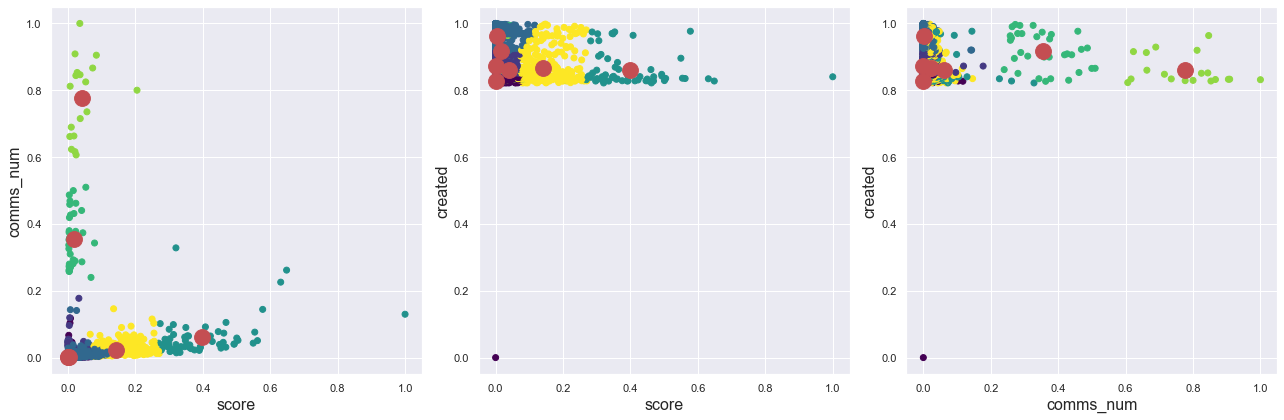

In [10]:
X = data[['score', 'comms_num', 'created']]
X_scaled=MinMaxScaler().fit_transform(X)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax = np.ravel(ax)

k=7
model = KMeans(n_clusters=k).fit(X_scaled)
preds = model.predict(X_scaled)
centroids = model.cluster_centers_

ax[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=preds, cmap='viridis')
ax[0].scatter(centroids[:, 0], centroids[:, 1], marker='o', c='r', s=250) 
ax[0].set_xlabel("score", fontsize=16)
ax[0].set_ylabel("comms_num", fontsize=16)

ax[1].scatter(X_scaled[:, 0], X_scaled[:, 2], c=preds, cmap='viridis')
ax[1].scatter(centroids[:, 0], centroids[:, 2], marker='o', c='r', s=250) 
ax[1].set_xlabel("score", fontsize=16)
ax[1].set_ylabel("created", fontsize=16)

ax[2].scatter(X_scaled[:, 1], X_scaled[:, 2], c=preds, cmap='viridis')
ax[2].scatter(centroids[:, 1], centroids[:, 2], marker='o', c='r', s=250) 
ax[2].set_xlabel("comms_num", fontsize=16)
ax[2].set_ylabel("created", fontsize=16)

plt.tight_layout()
plt.show()

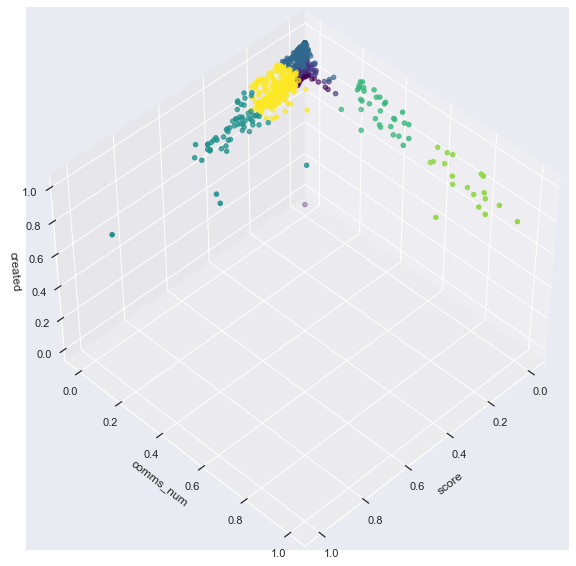

In [11]:
fig = plt.figure(figsize=(10, 10))
ax= fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c = preds, cmap = "viridis")
ax.set_xlabel('score')
ax.set_ylabel('comms_num')
ax.set_zlabel('created')
ax.view_init(45, 45)
plt.show()